In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, expr,sum, when,lit
from pyspark.ml.feature import MinMaxScaler

import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, NumericType

import seaborn as sns

from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import corr, when
from pyspark.sql.functions import max, min
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [2]:
spark = SparkSession.builder.getOrCreate()

Thu thập data

In [3]:
df_train = spark.read.csv('application_train.csv', header=True, inferSchema=True)
df_prev = spark.read.csv('previous_application.csv', header=True, inferSchema=True)

# Xem qua dữ liệu

In [4]:
df_train.show(5)

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------

In [5]:
df_prev.show(5)

+----------+----------+------------------+-----------+---------------+----------+----------------+---------------+--------------------------+-----------------------+---------------------------+----------------------+-----------------+---------------------+------------------------+----------------------+--------------------+-------------+--------------------+------------------+---------------+----------------+-------------------+--------------+-----------------+--------------------+----------------+--------------------+-----------+----------------+--------------------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+
|SK_ID_PREV|SK_ID_CURR|NAME_CONTRACT_TYPE|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|FLAG_LAST_APPL_PER_CONTRACT|NFLAG_LAST_APPL_IN_DAY|RATE_DOWN_PAYMENT|RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|NAME_CASH_LOAN_PURPOSE|NAME

# Phân tích và tổng hợp dữ liệu

In [6]:
print(df_train.select('SK_ID_CURR').distinct().count())
print(df_train.select('SK_ID_CURR').count())

307511
307511


In [7]:
print(df_prev.select('SK_ID_CURR').distinct().count())
print(df_prev.select('SK_ID_CURR').count())

338857
1670214


In [9]:
df_prev_agg = df_prev.groupBy('SK_ID_CURR').agg(
    F.count('SK_ID_PREV').alias('PREV_LOAN_COUNT'),
  
    F.sum('AMT_ANNUITY').alias('PREV_ANNUITY_SUM'),
    F.mean('AMT_ANNUITY').alias('PREV_ANNUITY_MEAN'),
    
    F.sum('AMT_APPLICATION').alias('PREV_APPLICATION_SUM'),
    F.mean('AMT_APPLICATION').alias('PREV_APPLICATION_MEAN'),
    
    F.sum('AMT_DOWN_PAYMENT').alias('PREV_DOWN_PAYMENT_SUM'),
    F.mean('AMT_DOWN_PAYMENT').alias('PREV_DOWN_PAYMENT_MEAN'),
    
    F.sum('AMT_GOODS_PRICE').alias('PREV_GOODS_PRICE_SUM'),
    F.mean('AMT_GOODS_PRICE').alias('PREV_GOODS_PRICE_MEAN'),
    
    F.sum('CNT_PAYMENT').alias('PREV_PAYMENT_COUNT_SUM'),
    F.mean('CNT_PAYMENT').alias('PREV_PAYMENT_COUNT_MEAN'),
    
    F.sum('RATE_DOWN_PAYMENT').alias('PREV_RATE_DOWN_PAYMENT_SUM'),
    F.mean('RATE_DOWN_PAYMENT').alias('PREV_RATE_DOWN_PAYMENT_MEAN'),
    
    F.sum(F.when(F.col('NAME_CONTRACT_TYPE') == 'Cash loans', 1).otherwise(0)).alias('PREV_TYPE_CASH'),
    F.sum(F.when(F.col('NAME_CONTRACT_TYPE') == 'Consumer loans', 1).otherwise(0)).alias('PREV_TYPE_CONSUMER'),
    F.sum(F.when(F.col('NAME_CONTRACT_TYPE') == 'Revolving loans', 1).otherwise(0)).alias('PREV_TYPE_REVOLVING'),
    
    F.sum(F.when(F.col('NAME_CONTRACT_STATUS') == 'Approved', 1).otherwise(0)).alias('PREV_STATUS_APPROVED'),
    F.sum(F.when(F.col('NAME_CONTRACT_STATUS') == 'Canceled', 1).otherwise(0)).alias('PREV_STATUS_CANCELED'),
    F.sum(F.when(F.col('NAME_CONTRACT_STATUS') == 'Refused', 1).otherwise(0)).alias('PREV_STATUS_REFUSED'),
    
    F.sum(F.when(F.col('NAME_CLIENT_TYPE') == 'New', 1).otherwise(0)).alias('PREV_CLIENT_TYPE_NEW'),
    F.sum(F.when(F.col('NAME_CLIENT_TYPE') == 'Refreshed', 1).otherwise(0)).alias('PREV_CLIENT_TYPE_REFRESHED'),
    F.sum(F.when(F.col('NAME_CLIENT_TYPE') == 'Repeater', 1).otherwise(0)).alias('PREV_CLIENT_TYPE_REPEATER')
)

df_prev_agg.show(5)


+----------+---------------+------------------+-----------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+
|SK_ID_CURR|PREV_LOAN_COUNT|  PREV_ANNUITY_SUM|PREV_ANNUITY_MEAN|PREV_APPLICATION_SUM|PREV_APPLICATION_MEAN|PREV_DOWN_PAYMENT_SUM|PREV_DOWN_PAYMENT_MEAN|PREV_GOODS_PRICE_SUM|PREV_GOODS_PRICE_MEAN|PREV_PAYMENT_COUNT_SUM|PREV_PAYMENT_COUNT_MEAN|PREV_RATE_DOWN_PAYMENT_SUM|PREV_RATE_DOWN_PAYMENT_MEAN|PREV_TYPE_CASH|PREV_TYPE_CONSUMER|PREV_TYPE_REVOLVING|PREV_STATUS_APPROVED|PREV_STATUS_CANCELED|PREV_STATUS_REFUSED|PREV_CLIENT_TYPE_NEW|PREV_CLIENT_TYPE_REFRESHED|PREV_CLIENT_TYPE_REPEATER|
+----------+----------

In [10]:
null_counts = df_prev_agg.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_prev_agg.columns])
null_counts.show()

+----------+---------------+----------------+-----------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+
|SK_ID_CURR|PREV_LOAN_COUNT|PREV_ANNUITY_SUM|PREV_ANNUITY_MEAN|PREV_APPLICATION_SUM|PREV_APPLICATION_MEAN|PREV_DOWN_PAYMENT_SUM|PREV_DOWN_PAYMENT_MEAN|PREV_GOODS_PRICE_SUM|PREV_GOODS_PRICE_MEAN|PREV_PAYMENT_COUNT_SUM|PREV_PAYMENT_COUNT_MEAN|PREV_RATE_DOWN_PAYMENT_SUM|PREV_RATE_DOWN_PAYMENT_MEAN|PREV_TYPE_CASH|PREV_TYPE_CONSUMER|PREV_TYPE_REVOLVING|PREV_STATUS_APPROVED|PREV_STATUS_CANCELED|PREV_STATUS_REFUSED|PREV_CLIENT_TYPE_NEW|PREV_CLIENT_TYPE_REFRESHED|PREV_CLIENT_TYPE_REPEATER|
+----------+--------------

In [10]:
df_prev = df_prev.fillna(0)

In [11]:
df_train_merged = df_train.join(df_prev_agg, on='SK_ID_CURR', how='left')

Lọc dữ liệu theo lịch sử vay vốn và khách hàng vay tiền mặt

In [12]:
df_train_merged.select('NAME_CONTRACT_TYPE').distinct().show()

+------------------+
|NAME_CONTRACT_TYPE|
+------------------+
|   Revolving loans|
|        Cash loans|
+------------------+



In [13]:
df_train_filtered = df_train_merged.filter(F.col('PREV_LOAN_COUNT').isNotNull())
df_train_filtered = df_train_filtered.filter(F.col('NAME_CONTRACT_TYPE').isin('Cash loans'))

Lựa chọn cột để sử dụng trong phân tích 

In [26]:
columns = [
    'TARGET',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'CNT_CHILDREN',
    'NAME_FAMILY_STATUS',
    'CNT_FAM_MEMBERS',
    'AMT_INCOME_TOTAL',
    'AMT_GOODS_PRICE',
    'OCCUPATION_TYPE',
    'DAYS_BIRTH',
    'NAME_INCOME_TYPE',
    'DAYS_EMPLOYED',
    'EXT_SOURCE_2',
    'NAME_EDUCATION_TYPE',
    'REG_REGION_NOT_LIVE_REGION',
    'REGION_RATING_CLIENT',
    'PREV_ANNUITY_SUM',
    'PREV_ANNUITY_MEAN',
    'PREV_APPLICATION_SUM',
    'PREV_APPLICATION_MEAN',
    'PREV_DOWN_PAYMENT_SUM',
    'PREV_DOWN_PAYMENT_MEAN',
    'PREV_GOODS_PRICE_SUM',
    'PREV_GOODS_PRICE_MEAN',
    'PREV_PAYMENT_COUNT_SUM',
    'PREV_PAYMENT_COUNT_MEAN',
    'PREV_RATE_DOWN_PAYMENT_SUM',
    'PREV_RATE_DOWN_PAYMENT_MEAN',
    'PREV_TYPE_CASH',
    'PREV_TYPE_CONSUMER',
    'PREV_TYPE_REVOLVING',
    'PREV_STATUS_APPROVED',
    'PREV_STATUS_CANCELED',
    'PREV_STATUS_REFUSED',
    'PREV_CLIENT_TYPE_NEW',
    'PREV_CLIENT_TYPE_REFRESHED',
    'PREV_CLIENT_TYPE_REPEATER'
]


df_train_selected = df_train_filtered.select(columns)
test_columns = [col for col in columns if col != 'TARGET']

print("Train set: ", df_train_selected.count(), "rows", len(df_train_selected.columns), "columns")

Train set:  264668 rows 38 columns


Kiểm tra tỷ lệ nhãn mục tiêu

In [27]:
df_train_selected.filter(F.col('TARGET') == 1).count()

22366

In [28]:
df_train_selected.filter(F.col('TARGET') == 0).count()

242302

Kiểm tra tính logic của dữ liệu

In [29]:
df_train_selected.filter(F.col("CNT_CHILDREN") < 0).show()

+------+-----------+------------+---------------+------------+------------------+---------------+----------------+---------------+---------------+----------+----------------+-------------+------------+-------------------+--------------------------+--------------------+----------------+-----------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+
|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|AMT_INCOME_TOTAL|AMT_GOODS_PRICE|OCCUPATION_TYPE|DAYS_BIRTH|NAME_INCOME_TYPE|DAYS_EMPLOYED|EXT_SOURCE_2|NAME_EDUCATION_TYPE|REG_REGION_NOT_LIVE_REGION|REGION_RATING_CLIENT|PRE

In [31]:
df_train_selected.filter(F.col("DAYS_EMPLOYED") > 0).show()

+------+-----------+------------+---------------+------------+--------------------+---------------+----------------+---------------+---------------+----------+----------------+-------------+-------------------+--------------------+--------------------------+--------------------+------------------+------------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+
|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|  NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|AMT_INCOME_TOTAL|AMT_GOODS_PRICE|OCCUPATION_TYPE|DAYS_BIRTH|NAME_INCOME_TYPE|DAYS_EMPLOYED|       EXT_SOURCE_2| NAME_EDUCATION_TYPE|REG_REGION_NOT_LIVE_REGION|R

In [32]:
df_train_selected = df_train_selected.withColumn(
    "DAYS_EMPLOYED",
    F.when(F.col("DAYS_EMPLOYED") > 0, 0)
     .otherwise(F.col("DAYS_EMPLOYED"))
)

# Xử lí dữ liệu thiếu

In [33]:
df_train_selected.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_train_selected.columns]).show()

+------+-----------+------------+---------------+------------+------------------+---------------+----------------+---------------+---------------+----------+----------------+-------------+------------+-------------------+--------------------------+--------------------+----------------+-----------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+
|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|AMT_INCOME_TOTAL|AMT_GOODS_PRICE|OCCUPATION_TYPE|DAYS_BIRTH|NAME_INCOME_TYPE|DAYS_EMPLOYED|EXT_SOURCE_2|NAME_EDUCATION_TYPE|REG_REGION_NOT_LIVE_REGION|REGION_RATING_CLIENT|PRE

In [34]:
from pyspark.sql.functions import col, sum
null_counts_df = df_train_selected.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_train_selected.columns])
null_counts_row = null_counts_df.collect()[0].asDict()
null_columns = {column: count for column, count in null_counts_row.items() if count > 0}

for column, count in null_columns.items():
    print(f"Column: {column}, NULL Count: {count}")

Column: OCCUPATION_TYPE, NULL Count: 84388
Column: EXT_SOURCE_2, NULL Count: 535
Column: PREV_ANNUITY_SUM, NULL Count: 404
Column: PREV_ANNUITY_MEAN, NULL Count: 404
Column: PREV_DOWN_PAYMENT_SUM, NULL Count: 16478
Column: PREV_DOWN_PAYMENT_MEAN, NULL Count: 16478
Column: PREV_GOODS_PRICE_SUM, NULL Count: 965
Column: PREV_GOODS_PRICE_MEAN, NULL Count: 965
Column: PREV_PAYMENT_COUNT_SUM, NULL Count: 402
Column: PREV_PAYMENT_COUNT_MEAN, NULL Count: 402
Column: PREV_RATE_DOWN_PAYMENT_SUM, NULL Count: 16478
Column: PREV_RATE_DOWN_PAYMENT_MEAN, NULL Count: 16478


In [35]:
df_train_selected = df_train_selected.withColumn(
    "OCCUPATION_TYPE",
    F.when(F.col("OCCUPATION_TYPE").isNull(), "Unknown").otherwise(F.col("OCCUPATION_TYPE"))
)

In [38]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
df_sorted = df_train_selected.select("EXT_SOURCE_2").filter(df_train_selected["EXT_SOURCE_2"].isNotNull()).orderBy("EXT_SOURCE_2")
count = df_sorted.count()
if count % 2 == 0:
    median1 = df_sorted.collect()[count // 2 - 1][0]
    median2 = df_sorted.collect()[count // 2][0]
    median_ext_source_2 = (median1 + median2) / 2
else:
    median_ext_source_2 = df_sorted.collect()[count // 2][0]

df_train_selected = df_train_selected.withColumn("EXT_SOURCE_2", 
                          F.when(df_train_selected["EXT_SOURCE_2"].isNull(), median_ext_source_2)
                           .otherwise(df_train_selected["EXT_SOURCE_2"]))

In [39]:
df_train_selected = df_train_selected.fillna(0)

# Feature Engineering

In [40]:
occ = []
for i in df_train_selected.select('OCCUPATION_TYPE').distinct().collect():
  occ.append(i[0])
occ

['Managers',
 'HR staff',
 'Medicine staff',
 'Accountants',
 'Laborers',
 'Unknown',
 'Cleaning staff',
 'Private service staff',
 'Drivers',
 'Sales staff',
 'Realty agents',
 'IT staff',
 'Security staff',
 'Secretaries',
 'Low-skill Laborers',
 'Core staff',
 'Cooking staff',
 'High skill tech staff',
 'Waiters/barmen staff']

In [41]:
df_train_selected = df_train_selected.withColumn("job_group", F.when(F.col("OCCUPATION_TYPE").isin( # Changed 'occupation' to 'OCCUPATION_TYPE'
    "Managers", "HR staff", "Secretaries", "Core staff"), "Management & Admin Support")
    .when(F.col("OCCUPATION_TYPE").isin( # Changed 'occupation' to 'OCCUPATION_TYPE'
    "Medicine staff", "IT staff", "Accountants", "High skill tech staff", "Realty agents"), "Professional/Technical")
    .when(F.col("OCCUPATION_TYPE").isin( # Changed 'occupation' to 'OCCUPATION_TYPE'
    "Sales staff", "Private service staff", "Waiters/barmen staff", "Cooking staff", "Drivers"), "Service & Sales")
    .otherwise("Other occupation")
)

In [42]:
df_train_selected.select('job_group').distinct().show()

+--------------------+
|           job_group|
+--------------------+
|     Service & Sales|
|    Other occupation|
|Professional/Tech...|
|Management & Admi...|
+--------------------+



In [43]:
df_train_selected.describe().show()

+-------+-------------------+-----------+------------+---------------+-------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------------+--------------------+-----------------+------------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+-----------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+--------------------+
|summary|             TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|       CNT_CHILDREN|NAME_FAMILY_STATUS|   CNT_FAM_MEMBERS|  AMT_INCOME_TOTAL|  AMT_GOODS_PRICE|     OCCUPATI

# Xử lí outliers

In [44]:
percentile = df_train_selected.approxQuantile(
    ["DAYS_EMPLOYED"],
    [0.25, 0.75],0.01)

Q1 = percentile[0][0]
Q3 = percentile[0][1]

IQR = Q3 - Q1
from pyspark.sql.functions import col

df_outliers = df_train_selected.filter(
    (col("DAYS_EMPLOYED") < (Q1 - 1.5 * IQR)) |
    (col("DAYS_EMPLOYED") > (Q3 + 1.5 * IQR))
)


df_outliers.show()

+------+-----------+------------+---------------+------------+--------------------+---------------+----------------+---------------+--------------------+----------+--------------------+-------------+-------------------+--------------------+--------------------------+--------------------+------------------+------------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+--------------------+
|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|  NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|AMT_INCOME_TOTAL|AMT_GOODS_PRICE|     OCCUPATION_TYPE|DAYS_BIRTH|    NAME_INCOME_TYPE|DAYS_EMPLOYED|       EXT_SOURCE_2| NAME_EDUC

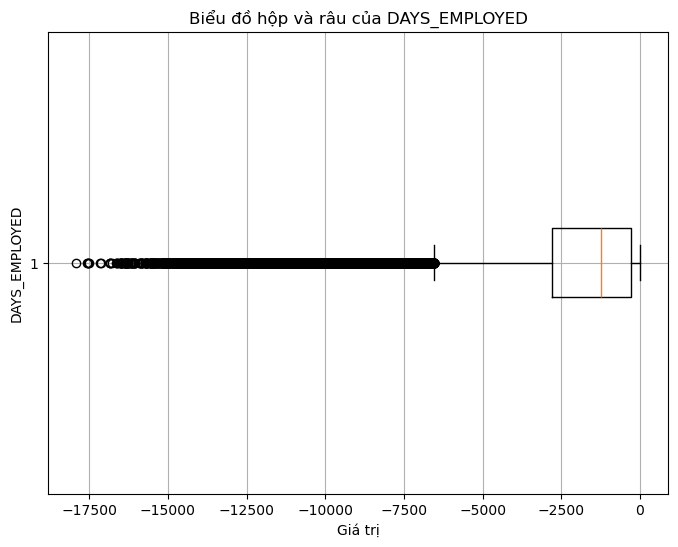

In [45]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
pandas_series = df_train_selected.select('DAYS_EMPLOYED').toPandas()['DAYS_EMPLOYED']

plt.figure(figsize=(8,6))
plt.boxplot(pandas_series, vert=False)
plt.title('Biểu đồ hộp và râu của DAYS_EMPLOYED')
plt.xlabel('Giá trị')
plt.ylabel('DAYS_EMPLOYED')
plt.grid(True)
plt.show()

In [46]:
df_train_selected.count()

264668

In [47]:
columns = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE']
quantiles = {col: df_train_selected.approxQuantile(col, [0.25, 0.75], 0.05) for col in columns}
for col in columns:
    q25, q75 = quantiles[col]
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    df_train_selected1 = df_train_selected.filter((F.col(col) >= lower_bound) & (F.col(col) <= upper_bound))

df_train_selected1.count()


251669

Tạo cột AGE từ DAYS_BIRTH

In [48]:
df_train_selected = df_train_selected.withColumn(
    'AGE', 
    (F.col('DAYS_BIRTH') * -1 / 365).cast('int')
)

df_train_selected.show()

+------+-----------+------------+---------------+------------+--------------------+---------------+----------------+---------------+--------------------+----------+--------------------+-------------+-------------------+--------------------+--------------------------+--------------------+------------------+------------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+--------------------+---+
|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|  NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|AMT_INCOME_TOTAL|AMT_GOODS_PRICE|     OCCUPATION_TYPE|DAYS_BIRTH|    NAME_INCOME_TYPE|DAYS_EMPLOYED|       EXT_SOURCE_2| NAME_

# Trực quan hóa dữ liệu

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


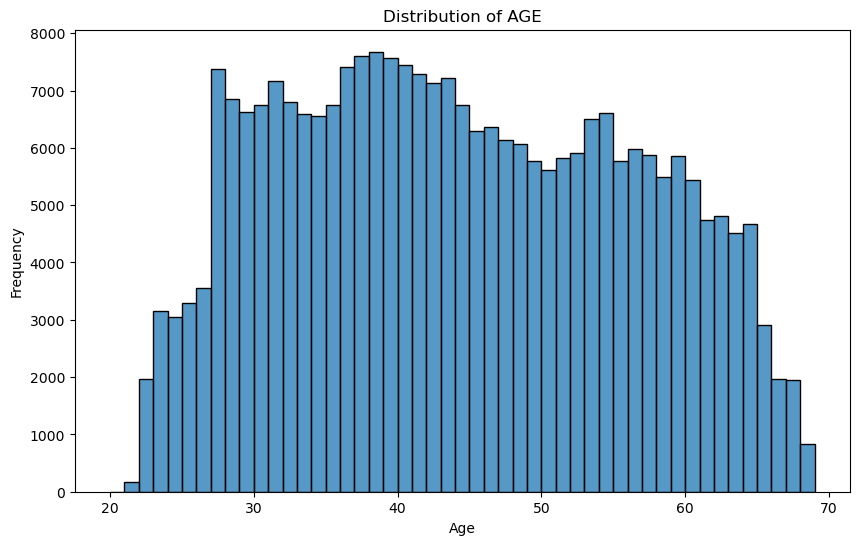

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
df_age = df_train_selected.select('AGE').toPandas()
plt.figure(figsize=(10, 6))

sns.histplot(df_age['AGE'], bins=range(int(df_age['AGE'].min()), int(df_age['AGE'].max()) + 1), edgecolor='k', kde=False)

plt.title('Distribution of AGE')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

Lọc dữ liệu của khách hàng có độ tuổi từ 28 đến 65 tuổi

In [49]:
df_filtered = df_train_selected.filter((df_train_selected.AGE >= 28) & (df_train_selected.AGE <= 65))

df_train_selected = df_filtered

In [56]:
df_train_selected = df_train_selected.filter(df_train_selected['DAYS_EMPLOYED'] >= -17155)

df_train_selected.count()

236474

In [57]:
df_train_cleaned_copy = df_train_selected.select('*')

# Chuẩn hóa dữ liệu

In [58]:
df_train_cleaned_copy.select('CODE_GENDER').distinct().show()

+-----------+
|CODE_GENDER|
+-----------+
|          F|
|          M|
+-----------+



In [59]:
indexer1 = StringIndexer(inputCol="CODE_GENDER", outputCol="CODE_GENDER_INDEX")
df_indexed = indexer1.fit(df_train_cleaned_copy).transform(df_train_cleaned_copy)

In [60]:
df_indexed.select('FLAG_OWN_CAR').distinct().show()

+------------+
|FLAG_OWN_CAR|
+------------+
|           Y|
|           N|
+------------+



In [61]:
indexer2 = StringIndexer(inputCol="FLAG_OWN_CAR", outputCol="FLAG_OWN_CAR_INDEX")
df_indexed = indexer2.fit(df_indexed).transform(df_indexed)
df_indexed.select('FLAG_OWN_CAR_INDEX').distinct().show()

+------------------+
|FLAG_OWN_CAR_INDEX|
+------------------+
|               0.0|
|               1.0|
+------------------+



In [62]:
df_indexed.select('FLAG_OWN_CAR_INDEX').distinct().show()

+------------------+
|FLAG_OWN_CAR_INDEX|
+------------------+
|               0.0|
|               1.0|
+------------------+



In [63]:
df_indexed.select('FLAG_OWN_REALTY').distinct().show()

+---------------+
|FLAG_OWN_REALTY|
+---------------+
|              Y|
|              N|
+---------------+



In [64]:
indexer3 = StringIndexer(inputCol="FLAG_OWN_REALTY", outputCol="FLAG_OWN_REALTY_INDEX")
df_indexed = indexer3.fit(df_indexed).transform(df_indexed)
df_indexed.select('FLAG_OWN_REALTY_INDEX').distinct().show()

+---------------------+
|FLAG_OWN_REALTY_INDEX|
+---------------------+
|                  0.0|
|                  1.0|
+---------------------+



In [65]:
df_indexed.select('job_group').distinct().show()

+--------------------+
|           job_group|
+--------------------+
|     Service & Sales|
|    Other occupation|
|Professional/Tech...|
|Management & Admi...|
+--------------------+



In [66]:
indexer4 = StringIndexer(inputCol="job_group", outputCol="job_group_index")
df_indexed = indexer4.fit(df_indexed).transform(df_indexed)
df_indexed.select('job_group_index').distinct().show()

+---------------+
|job_group_index|
+---------------+
|            0.0|
|            1.0|
|            3.0|
|            2.0|
+---------------+



In [67]:
df_indexed.select('NAME_FAMILY_STATUS').distinct().show()

+--------------------+
|  NAME_FAMILY_STATUS|
+--------------------+
|           Separated|
|             Married|
|Single / not married|
|               Widow|
|      Civil marriage|
+--------------------+



In [68]:
indexer5 = StringIndexer(inputCol="NAME_FAMILY_STATUS", outputCol="NAME_FAMILY_STATUS_INDEX")
df_indexed = indexer5.fit(df_indexed).transform(df_indexed)
df_indexed.select('NAME_FAMILY_STATUS_INDEX').distinct().show()

+------------------------+
|NAME_FAMILY_STATUS_INDEX|
+------------------------+
|                     0.0|
|                     1.0|
|                     4.0|
|                     3.0|
|                     2.0|
+------------------------+



In [69]:
df_indexed.show()

+------+-----------+------------+---------------+------------+--------------------+---------------+----------------+---------------+--------------------+----------+--------------------+-------------+-------------------+--------------------+--------------------------+--------------------+------------------+------------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+--------------------+---+-----------------+------------------+---------------------+---------------+------------------------+
|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|  NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|AMT_INCOME_TOTAL|AMT_GOODS

# Lọc lại các cột để xây dựng mô hình

In [70]:
df_indexed.columns

['TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'NAME_FAMILY_STATUS',
 'CNT_FAM_MEMBERS',
 'AMT_INCOME_TOTAL',
 'AMT_GOODS_PRICE',
 'OCCUPATION_TYPE',
 'DAYS_BIRTH',
 'NAME_INCOME_TYPE',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_2',
 'NAME_EDUCATION_TYPE',
 'REG_REGION_NOT_LIVE_REGION',
 'REGION_RATING_CLIENT',
 'PREV_ANNUITY_SUM',
 'PREV_ANNUITY_MEAN',
 'PREV_APPLICATION_SUM',
 'PREV_APPLICATION_MEAN',
 'PREV_DOWN_PAYMENT_SUM',
 'PREV_DOWN_PAYMENT_MEAN',
 'PREV_GOODS_PRICE_SUM',
 'PREV_GOODS_PRICE_MEAN',
 'PREV_PAYMENT_COUNT_SUM',
 'PREV_PAYMENT_COUNT_MEAN',
 'PREV_RATE_DOWN_PAYMENT_SUM',
 'PREV_RATE_DOWN_PAYMENT_MEAN',
 'PREV_TYPE_CASH',
 'PREV_TYPE_CONSUMER',
 'PREV_TYPE_REVOLVING',
 'PREV_STATUS_APPROVED',
 'PREV_STATUS_CANCELED',
 'PREV_STATUS_REFUSED',
 'PREV_CLIENT_TYPE_NEW',
 'PREV_CLIENT_TYPE_REFRESHED',
 'PREV_CLIENT_TYPE_REPEATER',
 'job_group',
 'AGE',
 'CODE_GENDER_INDEX',
 'FLAG_OWN_CAR_INDEX',
 'FLAG_OWN_REALTY_INDEX',
 'job_group_index',
 'NAME_FA

In [77]:
coef = dict()

In [78]:
df_train_cleaned_copy.select(corr('TARGET', 'EXT_SOURCE_2')).show()

+--------------------------+
|corr(TARGET, EXT_SOURCE_2)|
+--------------------------+
|      -0.15806693875847633|
+--------------------------+



In [79]:
df_indexed.printSchema()

root
 |-- TARGET: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = false)
 |-- AMT_INCOME_TOTAL: double (nullable = false)
 |-- AMT_GOODS_PRICE: double (nullable = false)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- EXT_SOURCE_2: double (nullable = false)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- REG_REGION_NOT_LIVE_REGION: integer (nullable = true)
 |-- REGION_RATING_CLIENT: integer (nullable = true)
 |-- PREV_ANNUITY_SUM: double (nullable = false)
 |-- PREV_ANNUITY_MEAN: double (nullable = false)
 |-- PREV_APPLICATION_SUM: double (nullable = false)
 |-- PREV_APPLICATION_MEAN: double (nu

In [80]:
for col in df_indexed.columns:
  coef[col] = df_indexed.select(corr('TARGET', col)).collect()[0][0]

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:695)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:660)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:636)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:582)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:541)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [81]:
del coef['CODE_GENDER']
del coef['FLAG_OWN_CAR']
del coef['FLAG_OWN_REALTY']
del coef['job_group']
del coef['NAME_FAMILY_STATUS']
del coef['OCCUPATION_TYPE']
del coef['DAYS_BIRTH']

In [82]:
sorted_coef = sorted(
    [(k, v) for k, v in coef.items() if v is not None],
    key=lambda x: abs(x[1]), reverse=True
)
sorted_coef

[('TARGET', 1.0),
 ('EXT_SOURCE_2', -0.15806693875847633),
 ('AGE', -0.07285294501705304),
 ('PREV_STATUS_REFUSED', 0.06909835666735042),
 ('CODE_GENDER_INDEX', 0.05851535871598681),
 ('REGION_RATING_CLIENT', 0.058171289547171726),
 ('PREV_TYPE_REVOLVING', 0.04830847026234186),
 ('PREV_CLIENT_TYPE_NEW', 0.04772732591914206),
 ('AMT_GOODS_PRICE', -0.04480703053347775),
 ('DAYS_EMPLOYED', 0.042611923993692305),
 ('PREV_RATE_DOWN_PAYMENT_SUM', -0.041813578606776716),
 ('PREV_RATE_DOWN_PAYMENT_MEAN', -0.037053780391258256),
 ('PREV_PAYMENT_COUNT_MEAN', 0.033738913980881836),
 ('PREV_PAYMENT_COUNT_SUM', 0.033334396646764776),
 ('PREV_ANNUITY_MEAN', -0.03167456312653974),
 ('job_group_index', -0.029919408977505266),
 ('PREV_TYPE_CASH', 0.02922709780103835),
 ('PREV_STATUS_APPROVED', -0.02854427018595943),
 ('PREV_DOWN_PAYMENT_SUM', -0.025889364913613783),
 ('PREV_DOWN_PAYMENT_MEAN', -0.024827260580249005),
 ('PREV_TYPE_CONSUMER', -0.02315733147517645),
 ('PREV_STATUS_CANCELED', 0.02273115722

In [83]:
for i in sorted_coef[1:21]:
  print(i[0])

EXT_SOURCE_2
AGE
PREV_STATUS_REFUSED
CODE_GENDER_INDEX
REGION_RATING_CLIENT
PREV_TYPE_REVOLVING
PREV_CLIENT_TYPE_NEW
AMT_GOODS_PRICE
DAYS_EMPLOYED
PREV_RATE_DOWN_PAYMENT_SUM
PREV_RATE_DOWN_PAYMENT_MEAN
PREV_PAYMENT_COUNT_MEAN
PREV_PAYMENT_COUNT_SUM
PREV_ANNUITY_MEAN
job_group_index
PREV_TYPE_CASH
PREV_STATUS_APPROVED
PREV_DOWN_PAYMENT_SUM
PREV_DOWN_PAYMENT_MEAN
PREV_TYPE_CONSUMER


In [84]:
feature = [i[0] for i in sorted_coef[1:]]
figure = [abs(i[1]) for i in sorted_coef[1:]]


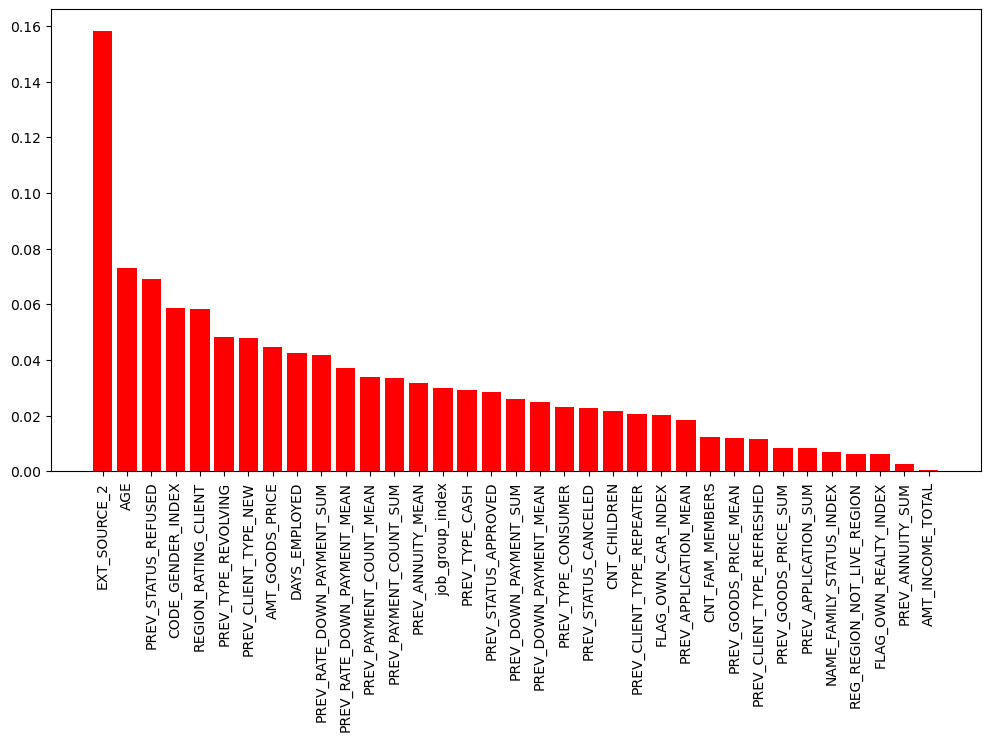

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  

plt.bar(feature, figure, color='red')

plt.xticks(rotation=90)

plt.show()


# One hot encoder

In [86]:
encoder1 = OneHotEncoder(inputCol="CODE_GENDER_INDEX", outputCol="CODE_GENDER_VEC")
df_indexed = encoder1.fit(df_indexed).transform(df_indexed)

encoder2 = OneHotEncoder(inputCol="FLAG_OWN_CAR_INDEX", outputCol="FLAG_OWN_CAR_VEC")
df_indexed = encoder2.fit(df_indexed).transform(df_indexed)

In [87]:
encoder3 = OneHotEncoder(inputCol="FLAG_OWN_REALTY_INDEX", outputCol="FLAG_OWN_REALTY_VEC")
df_indexed = encoder3.fit(df_indexed).transform(df_indexed)

encoder4 = OneHotEncoder(inputCol="job_group_index", outputCol="job_group_vec")
df_indexed = encoder4.fit(df_indexed).transform(df_indexed)

encoder5 = OneHotEncoder(inputCol="NAME_FAMILY_STATUS_INDEX", outputCol="NAME_FAMILY_STATUS_VEC")
df_indexed = encoder5.fit(df_indexed).transform(df_indexed)


In [88]:
df_indexed = df_indexed.drop('CODE_GENDER_INDEX', 'FLAG_OWN_CAR_INDEX', 'FLAG_OWN_REALTY_INDEX', 'OCCUPATION_TYPE_INDEX', 'NAME_FAMILY_STATUS_INDEX', 'job_group_index')

In [89]:
df_indexed.show()

+------+-----------+------------+---------------+------------+--------------------+---------------+----------------+---------------+--------------------+----------+--------------------+-------------+-------------------+--------------------+--------------------------+--------------------+------------------+------------------+--------------------+---------------------+---------------------+----------------------+--------------------+---------------------+----------------------+-----------------------+--------------------------+---------------------------+--------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------------+-------------------------+--------------------+---+---------------+----------------+-------------------+-------------+----------------------+
|TARGET|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|  NAME_FAMILY_STATUS|CNT_FAM_MEMBERS|AMT_INCOME_TOTAL|AMT_GOODS_PRICE|   

# Xây dựng mô hình

In [91]:
assembler = VectorAssembler(
    inputCols=[
        'AGE',
        'PREV_STATUS_REFUSED',
        'CODE_GENDER_VEC',
        'REGION_RATING_CLIENT',
        'PREV_TYPE_REVOLVING',
        'PREV_CLIENT_TYPE_NEW',
        'AMT_GOODS_PRICE',
        'DAYS_EMPLOYED',
        'EXT_SOURCE_2',
        'PREV_RATE_DOWN_PAYMENT_SUM',
        'PREV_RATE_DOWN_PAYMENT_MEAN',
        'PREV_PAYMENT_COUNT_MEAN',
        'PREV_PAYMENT_COUNT_SUM',
        'PREV_ANNUITY_MEAN',
        'job_group_vec',
        'PREV_TYPE_CASH',
        'PREV_STATUS_APPROVED',
        'PREV_DOWN_PAYMENT_SUM',
        'PREV_DOWN_PAYMENT_MEAN',
        'PREV_TYPE_CONSUMER'
    ], 
    outputCol='features'
)

df_indexed = assembler.transform(df_indexed).select('features', 'TARGET')
df_indexed.show()

+--------------------+------+
|            features|TARGET|
+--------------------+------+
|[45.0,0.0,1.0,1.0...|     0|
|[54.0,0.0,0.0,2.0...|     0|
|(22,[0,3,5,6,7,8,...|     0|
|[41.0,8.0,1.0,2.0...|     0|
|[35.0,3.0,1.0,2.0...|     0|
|[29.0,0.0,0.0,2.0...|     0|
|[49.0,0.0,1.0,1.0...|     0|
|[35.0,0.0,1.0,2.0...|     0|
|[29.0,0.0,0.0,2.0...|     0|
|[41.0,2.0,0.0,2.0...|     0|
|(22,[0,1,2,3,6,7,...|     0|
|(22,[0,2,3,5,6,7,...|     0|
|[31.0,0.0,1.0,2.0...|     0|
|[52.0,3.0,1.0,2.0...|     0|
|[32.0,7.0,0.0,2.0...|     0|
|[40.0,0.0,1.0,2.0...|     0|
|[38.0,0.0,0.0,2.0...|     0|
|[32.0,1.0,0.0,3.0...|     0|
|[42.0,0.0,0.0,2.0...|     0|
|[65.0,2.0,0.0,1.0...|     0|
+--------------------+------+
only showing top 20 rows



In [92]:
df_indexed_train, df_indexed_test = df_indexed.randomSplit([0.7, 0.3])

In [93]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_indexed_train)
df_indexed_train = scaler_model.transform(df_indexed_train)
df_indexed_test = scaler_model.transform(df_indexed_test)

In [112]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, when
from sklearn.metrics import precision_recall_curve, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

lr = LogisticRegression(featuresCol='features', labelCol='TARGET')

eval = BinaryClassificationEvaluator(labelCol='TARGET')

param = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.threshold, [0.2, 0.8])
    .build()
)

cross = CrossValidator(estimator=lr, estimatorParamMaps=param, evaluator=eval, numFolds=5)

cv_model = cross.fit(df_indexed_train)

best_model = cv_model.bestModel
print("Best regularization parameter:", best_model._java_obj.getRegParam())
print("Best elasticNet parameter:", best_model._java_obj.getElasticNetParam())
print("Best threshold:", best_model._java_obj.getThreshold())


Best regularization parameter: 0.01
Best elasticNet parameter: 0.0
Best threshold: 0.2


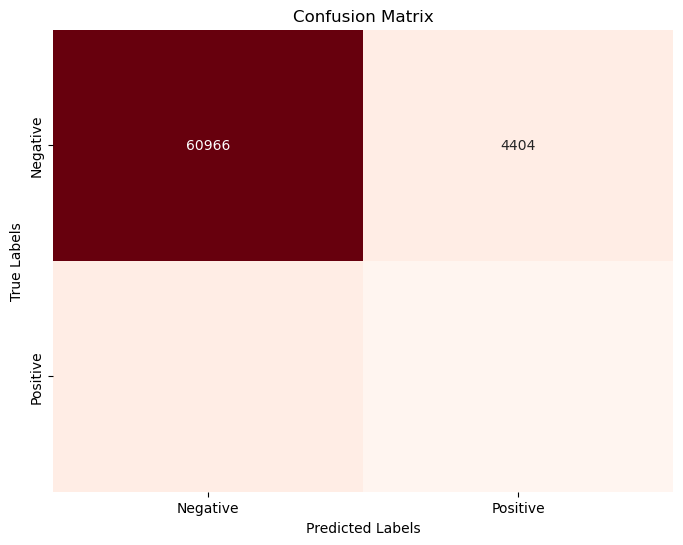

In [114]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Xây dựng lại mô hình từ thông số trên

In [167]:
lr_2_threshold = LogisticRegression(featuresCol='features', labelCol='TARGET', regParam=0.01, elasticNetParam=0.0, threshold=0.2)

In [171]:
df_train, df_val = df_train_cleaned_copy.randomSplit([0.7, 0.3])
df_valid, df_test = df_val.randomSplit([0.5, 0.5])

In [172]:
pipe_2 = Pipeline(stages=[
    indexer1,
    encoder1,
    indexer2,
    encoder2,
    indexer3,
    encoder3,
    indexer4,
    encoder4,
    indexer5,
    encoder5,
    assembler,
    scaler,
    lr_2_threshold
])


In [173]:
pipe_model = pipe_2.fit(df_train)
predict = pipe_model.transform(df_val)

In [174]:
predict.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [184]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predict)

evaluator_prec = MulticlassClassificationEvaluator(labelCol="TARGET",
                                                   predictionCol="prediction",
                                                   metricName="weightedPrecision")
precision = evaluator_prec.evaluate(predict)

evaluator_rec = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_rec.evaluate(predict)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predict)

evaluator_auc = BinaryClassificationEvaluator(labelCol="TARGET", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predict)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC: {auc}")

Accuracy: 0.8997708563184248
Precision: 0.8768521780765873
Recall: 0.8997708563184249
F1-Score: 0.886681814434805
AUC: 0.7034391080168727


In [195]:
logistic_model = pipe_model.stages[-1]  

print("Coefficients: " + str(logistic_model.coefficients))
print("Intercept: " + str(logistic_model.intercept))

Coefficients: [-0.021680351214319517,0.07137148440452855,-0.3501939521255475,0.14590156606125734,0.07921093224726145,0.12270806820228984,-1.0448818026977571e-07,4.622972919950935e-05,-2.1464237352197437,-0.24356859519083962,-0.40240237658982836,0.013788294971443092,0.0004724621459020153,-1.1685172499363601e-05,0.1039581186746454,0.23784615699668393,-0.07624049894986566,0.0010596289519201416,-0.04011723499130508,5.0674038437750875e-08,-1.0454018855177903e-06,-0.053054419448945955]
Intercept: -0.46017541403886186


In [186]:
predict.select('prediction').distinct().show()

+----------+
|prediction|
+----------+
|       0.0|
|       1.0|
+----------+



In [187]:
res_df = predict.select('prediction', 'TARGET')
res_df.show()

+----------+------+
|prediction|TARGET|
+----------+------+
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
+----------+------+
only showing top 20 rows



In [188]:
res = res_df.groupBy("TARGET", "prediction").count()
res.show()

+------+----------+-----+
|TARGET|prediction|count|
+------+----------+-----+
|     1|       0.0| 4776|
|     0|       0.0|62748|
|     1|       1.0|  864|
|     0|       1.0| 2310|
+------+----------+-----+



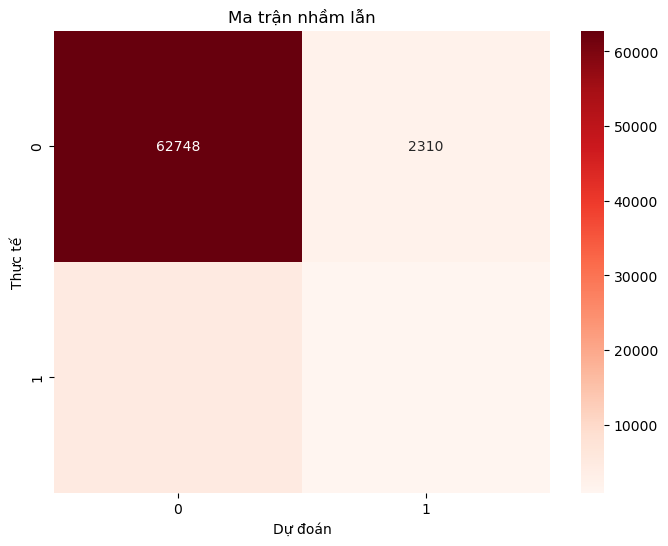

In [189]:
res_pd = res.toPandas()

conf_matrix = np.array([[0, 0], [0, 0]])

for index, row in res_pd.iterrows():
    target = int(row['TARGET'])
    prediction = int(row['prediction'])
    count = row['count']
    conf_matrix[target, prediction] = count
    
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn')
plt.show()

In [182]:
conf_matrix

array([[62748,  2310],
       [ 4776,   864]])

In [196]:
# Xuất mô hình
pipe_model.save('lr_hc')